In [35]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import random
import re
import os
import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras import metrics
from sklearn.metrics import recall_score
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import losses
from skimage.transform import resize
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from keras import backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
import visualkeras
from tensorflow.keras.regularizers import l2
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation, concatenate, GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D,Dropout

In [2]:
#Carrego les imatges

#ruta_no ='/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'
#ruta_yes = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'
ruta_no='/kaggle/input/brain-tumor-detection/no'
ruta_yes='/kaggle/input/brain-tumor-detection/yes'

labels = ['No Tumor', 'Tumor']


no_list = os.listdir(ruta_no)
yes_list = os.listdir(ruta_yes)

#Defineixo on guardaré les imatges
X = []
y = []
IMG_SIZE = (224, 224)

# Carrego les imatges amb tumor
for i in range(len(yes_list)):
    file_path = os.path.join(ruta_yes, yes_list[i])

    if os.path.exists(file_path):
        img = plt.imread(file_path)
        img_resized = resize(img, IMG_SIZE + (3,))  
        X.append(img_resized)
        y.append(1)
    else:
        print(f"File not found: {file_path}")

# Carrego les imatges sense tumor
for i in range(len(no_list)):
    file_path = os.path.join(ruta_no, no_list[i])
    if os.path.exists(file_path):
        img = plt.imread(file_path)
        img_resized = resize(img, IMG_SIZE + (3,))  
        X.append(img_resized)
        y.append(0)
    else:
        print(f"File not found: {file_path}")

X = np.array(X)
y = np.array(y)

# Shuffle data
X, y = shuffle(X, y, random_state=42)

In [3]:
def plot_sample_images(X, y, n=10):
    np.random.seed(15)  
    for label in [0, 1]:
        # Obtener índices de imágenes con la etiqueta correspondiente
        indices = np.where(y == label)[0]
        
        # Seleccionar aleatoriamente n índices
        selected_indices = np.random.choice(indices, n, replace=False)
        
        columns_n = 5
        rows_n = int(n / columns_n)

        plt.figure(figsize=(10, 8))

        i = 1  # índice actual
        for idx in selected_indices:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(X[idx])

            # Eliminar marcas
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()




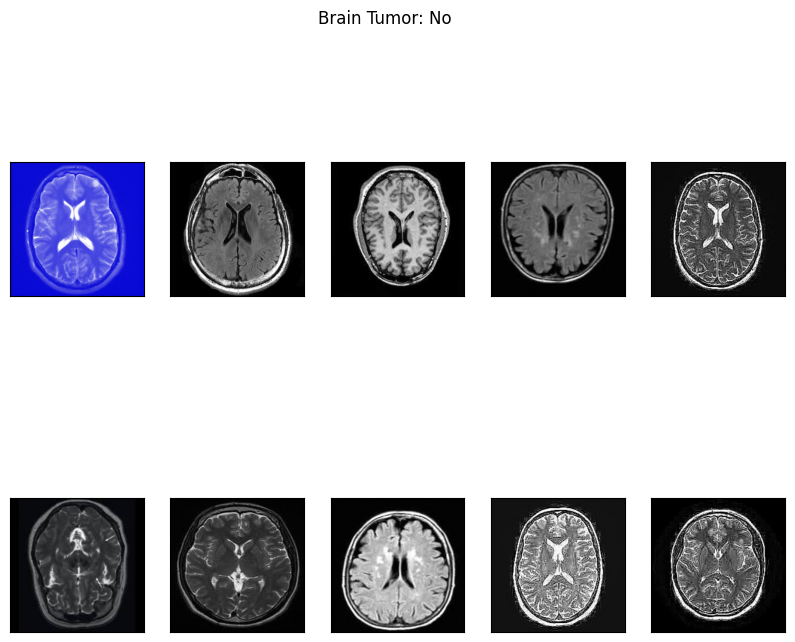

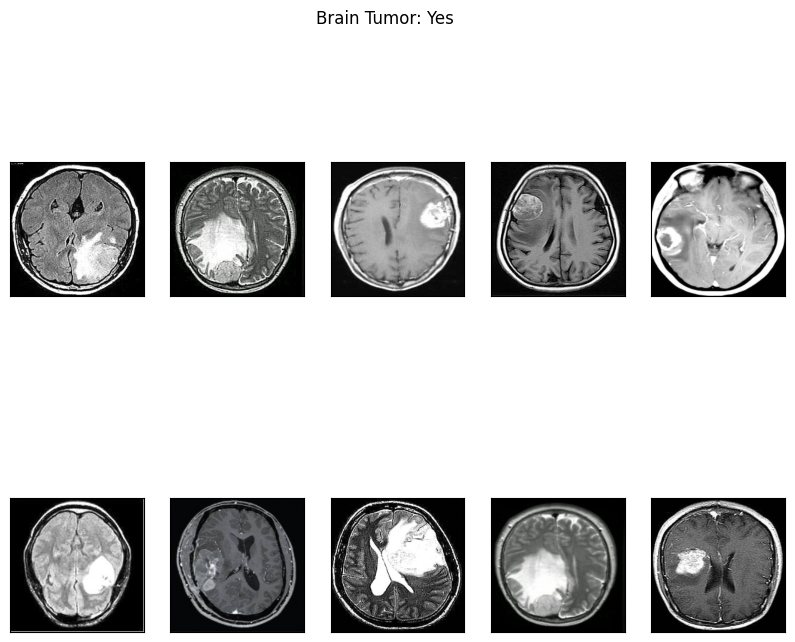

In [4]:
plot_sample_images(X, y)

In [5]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=test_size)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)

In [7]:
# Faig Data aumgmentation per tal de millorar la capacitat preductiva del model.
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


augmented_images = []
augmented_labels = []

for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]
    img = np.expand_dims(img, 0)
    label = np.expand_dims(label, 0)
    
    augmented_batch = datagen.flow(img, label, batch_size=1)
    augmented_image, augmented_label = augmented_batch.next()
    
    augmented_images.append(augmented_image[0])
    augmented_labels.append(augmented_label[0])

X_train_augmented = np.array(augmented_images)
y_train_augmented = np.array(augmented_labels)

X_train=X_train_augmented
y_train=y_train_augmented

In [8]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 2400
number of validation examples = 120
number of test examples = 480


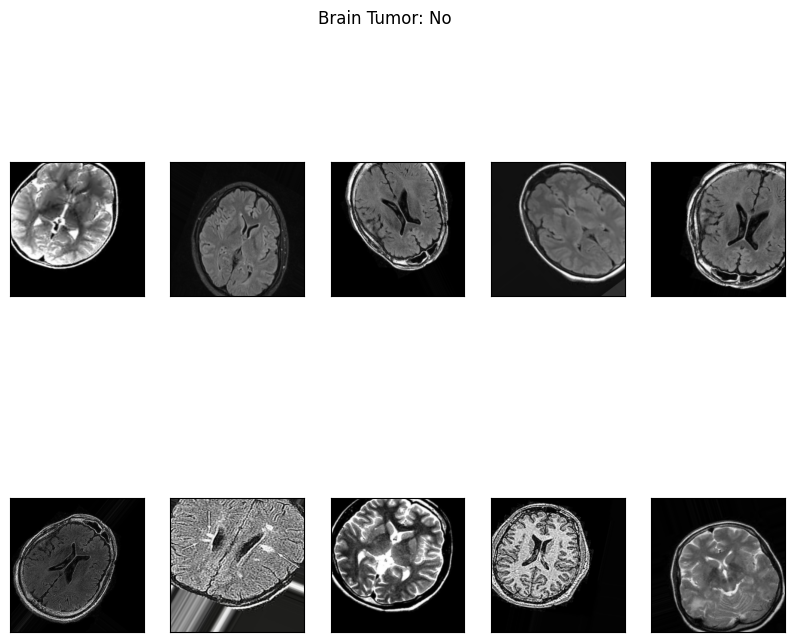

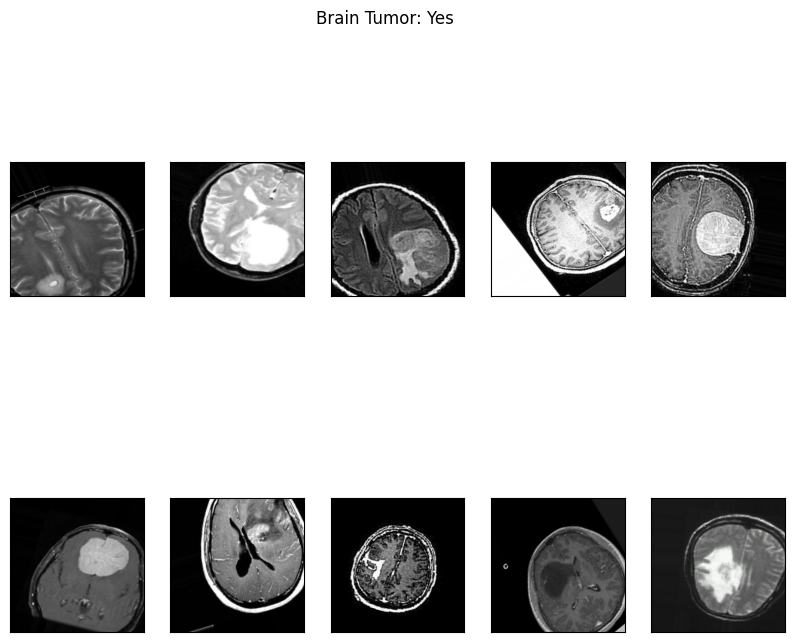

In [9]:
plot_sample_images(X_train, y_train)

In [10]:
# balanceig de dades:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class_weights_dict = {i: w for i, w in enumerate(class_weights)}

In [11]:
# asignem els hiperparametres corresponents a les imatges.
IMAGE_WIDTH=224 # amplada de les fotos
IMAGE_HEIGHT=224 # alçada de les fotos
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT) # definim el tamany total de les imatges. 
IMAGE_CHANNELS=3 # asignem que la imatge te 3 canals ja que és una imatge en color i per tant te una capa RED, una GREEN i una BLUE.
batch_size=16
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Normalitzo les imatges:
X_train=X_train/255.0

In [12]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    
    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((4, 4))(X)
    #X = MaxPooling2D((4, 4))(X)
    
    X = Flatten()(X)
    X = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(X)
    X = tf.keras.layers.Dropout(0.7)(X) 
    
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [14]:
IMG_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
#model=build_model(IMG_SHAPE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 4)       112       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 4)       16        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      2368      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                        

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])

history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    class_weight=class_weights_dict)

Epoch 1/50
150/150 [==============================] - 7s 18ms/step - loss: 0.6763 - recall: 0.6276 - val_loss: 9.4063 - val_recall: 1.0000
Epoch 2/50
150/150 [==============================] - 2s 14ms/step - loss: 0.6471 - recall: 0.5906 - val_loss: 35.6044 - val_recall: 1.0000
Epoch 3/50
150/150 [==============================] - 2s 14ms/step - loss: 0.6269 - recall: 0.6529 - val_loss: 78.5894 - val_recall: 1.0000
Epoch 4/50
150/150 [==============================] - 2s 15ms/step - loss: 0.5895 - recall: 0.7313 - val_loss: 421.8509 - val_recall: 1.0000
Epoch 5/50
150/150 [==============================] - 2s 15ms/step - loss: 0.5435 - recall: 0.7666 - val_loss: 520.1354 - val_recall: 1.0000
Epoch 6/50
150/150 [==============================] - 2s 15ms/step - loss: 0.4639 - recall: 0.7961 - val_loss: 1138.7853 - val_recall: 1.0000


In [16]:
# Crear el modelo base preentrenado (VGG16 en este caso)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas al modelo base
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(8,activation='relu')(x)
x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.001))(x)

# Crear el modelo completo
model_vgg16 = Model(inputs=base_model.input, outputs=output)
model_vgg16.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
# VGG16
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])

history_vgg16 = model_vgg16.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=15,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])
#class_weight=class_weights_dict

Epoch 1/15
150/150 [==============================] - 17s 77ms/step - loss: 0.6345 - recall: 0.6622 - val_loss: 3.6160 - val_recall: 0.9844
Epoch 2/15
150/150 [==============================] - 10s 64ms/step - loss: 0.5675 - recall: 0.7195 - val_loss: 27.9172 - val_recall: 1.0000
Epoch 3/15
150/150 [==============================] - 10s 65ms/step - loss: 0.5542 - recall: 0.7405 - val_loss: 42.1831 - val_recall: 1.0000
Epoch 4/15
150/150 [==============================] - 10s 66ms/step - loss: 0.5408 - recall: 0.7397 - val_loss: 81.4000 - val_recall: 1.0000
Epoch 5/15
150/150 [==============================] - 10s 67ms/step - loss: 0.5298 - recall: 0.7228 - val_loss: 66.4663 - val_recall: 0.9688
Epoch 6/15
150/150 [==============================] - 10s 68ms/step - loss: 0.5167 - recall: 0.7304 - val_loss: 72.4581 - val_recall: 0.9688


In [25]:
# Predecir en los conjuntos de entrenamiento y validación
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Aplicar umbral de decisión si es necesario (por ejemplo, para convertir probabilidades en clases binarias)
threshold = 0.5
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_val_pred_binary = (y_val_pred > threshold).astype(int)

# Calcular el recall utilizando scikit-learn
train_recall = recall_score(y_train, y_train_pred_binary)
val_recall = recall_score(y_val, y_val_pred_binary)

print("Sensibilitat en el conjunt d'entrenament:", train_recall)
print("Sensibilitat en el conjunt de validació:", val_recall)

4/4 [==============================] - 0s 9ms/step
Sensibilitat en el conjunt d'entrenament: 0.0
Sensibilitat en el conjunt de validació: 1.0


In [26]:
# Predecir en los conjuntos de entrenamiento y validación
y_train_pred = model_vgg16.predict(X_train)
y_val_pred = model_vgg16.predict(X_val)

# Aplicar umbral de decisión si es necesario (por ejemplo, para convertir probabilidades en clases binarias)
threshold = 0.5
y_train_pred_binary_vgg = (y_train_pred > threshold).astype(int)
y_val_pred_binary_vgg = (y_val_pred > threshold).astype(int)

# Calcular el recall utilizando scikit-learn
train_recall_vgg = recall_score(y_train, y_train_pred_binary_vgg)
val_recall_vgg = recall_score(y_val, y_val_pred_binary_vgg)

print("Sensibilitat en el conjunt d'entrenament:", train_recall_vgg)
print("Sensibilitat en el conjunt de validació:", val_recall_vgg)

4/4 [==============================] - 0s 118ms/step
Sensibilitat en el conjunt d'entrenament: 1.0
Sensibilitat en el conjunt de validació: 0.984375


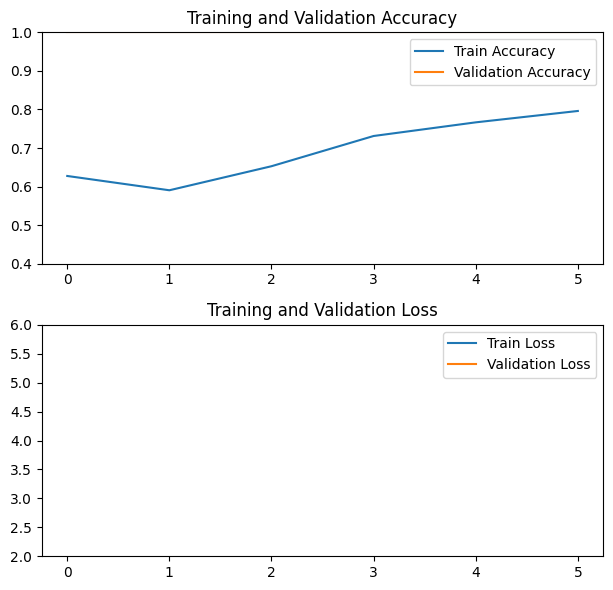

In [27]:
# Obtener métricas de entrenamiento y validación
train_acc = history.history['recall']
val_acc = history.history['val_recall']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráficos
plt.figure(figsize=(12, 6))

# Gráfico de precisión
plt.subplot(2, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0.4,1)

# Gráfico de pérdida
plt.subplot(2, 2, 3)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(2,6)

# Ajustar diseño y mostrar gráficos
plt.tight_layout()
plt.show()

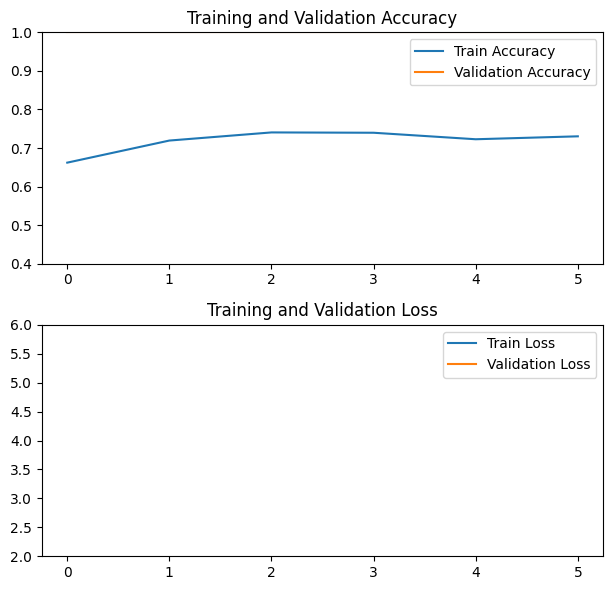

In [28]:
# VGG16
# Obtener métricas de entrenamiento y validación
train_acc = history_vgg16.history['recall']
val_acc = history.history['val_recall']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráficos
plt.figure(figsize=(12, 6))

# Gráfico de precisión
plt.subplot(2, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0.4,1)

# Gráfico de pérdida
plt.subplot(2, 2, 3)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(2,6)


# Ajustar diseño y mostrar gráficos
plt.tight_layout()
plt.show()


In [29]:
import matplotlib.pyplot as plt

# Función para graficar la historia de entrenamiento en una cuadrícula de 2x2
def plot_training_history_dual(model_history, vgg_history):
    plt.figure(figsize=(16, 12))

    # Gráfico de pérdida del modelo 
    plt.subplot(2, 2, 1)
    plt.plot(model_history.history['loss'], label='Training Loss (Model)')
    plt.plot(model_history.history['val_loss'], label='Validation Loss (Model)')
    plt.title('Training and Validation Loss (Model)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim()

    # Gráfico de precisión del modelo
    plt.subplot(2, 2, 3)
    plt.plot(model_history.history['recall'], label='Training Sensitivity (Model)')
    plt.plot(model_history.history['val_recall'], label='Validation Sensitivity (Model)')
    plt.title('Training and Validation Sensitivity (Model)')
    plt.xlabel('Epochs')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.ylim(0,1.2)


    # Gráfico de pérdida de VGG16 
    plt.subplot(2, 2, 2)
    plt.plot(vgg_history.history['loss'], label='Training Loss (VGG16)')
    plt.plot(vgg_history.history['val_loss'], label='Validation Loss (VGG16)')
    plt.title('Training and Validation Loss (VGG16)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    

    # Gráfico de precisión de VGG16 
    plt.subplot(2, 2, 4)
    plt.plot(vgg_history.history['recall'], label='Training Sensitivity (VGG16)')
    plt.plot(vgg_history.history['val_recall'], label='Validation Sensitivity (VGG16)')
    plt.title('Training and Validation Sensitivity (VGG16)')
    plt.xlabel('Epochs')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.ylim(0,1.2)

    plt.tight_layout()
    plt.show()

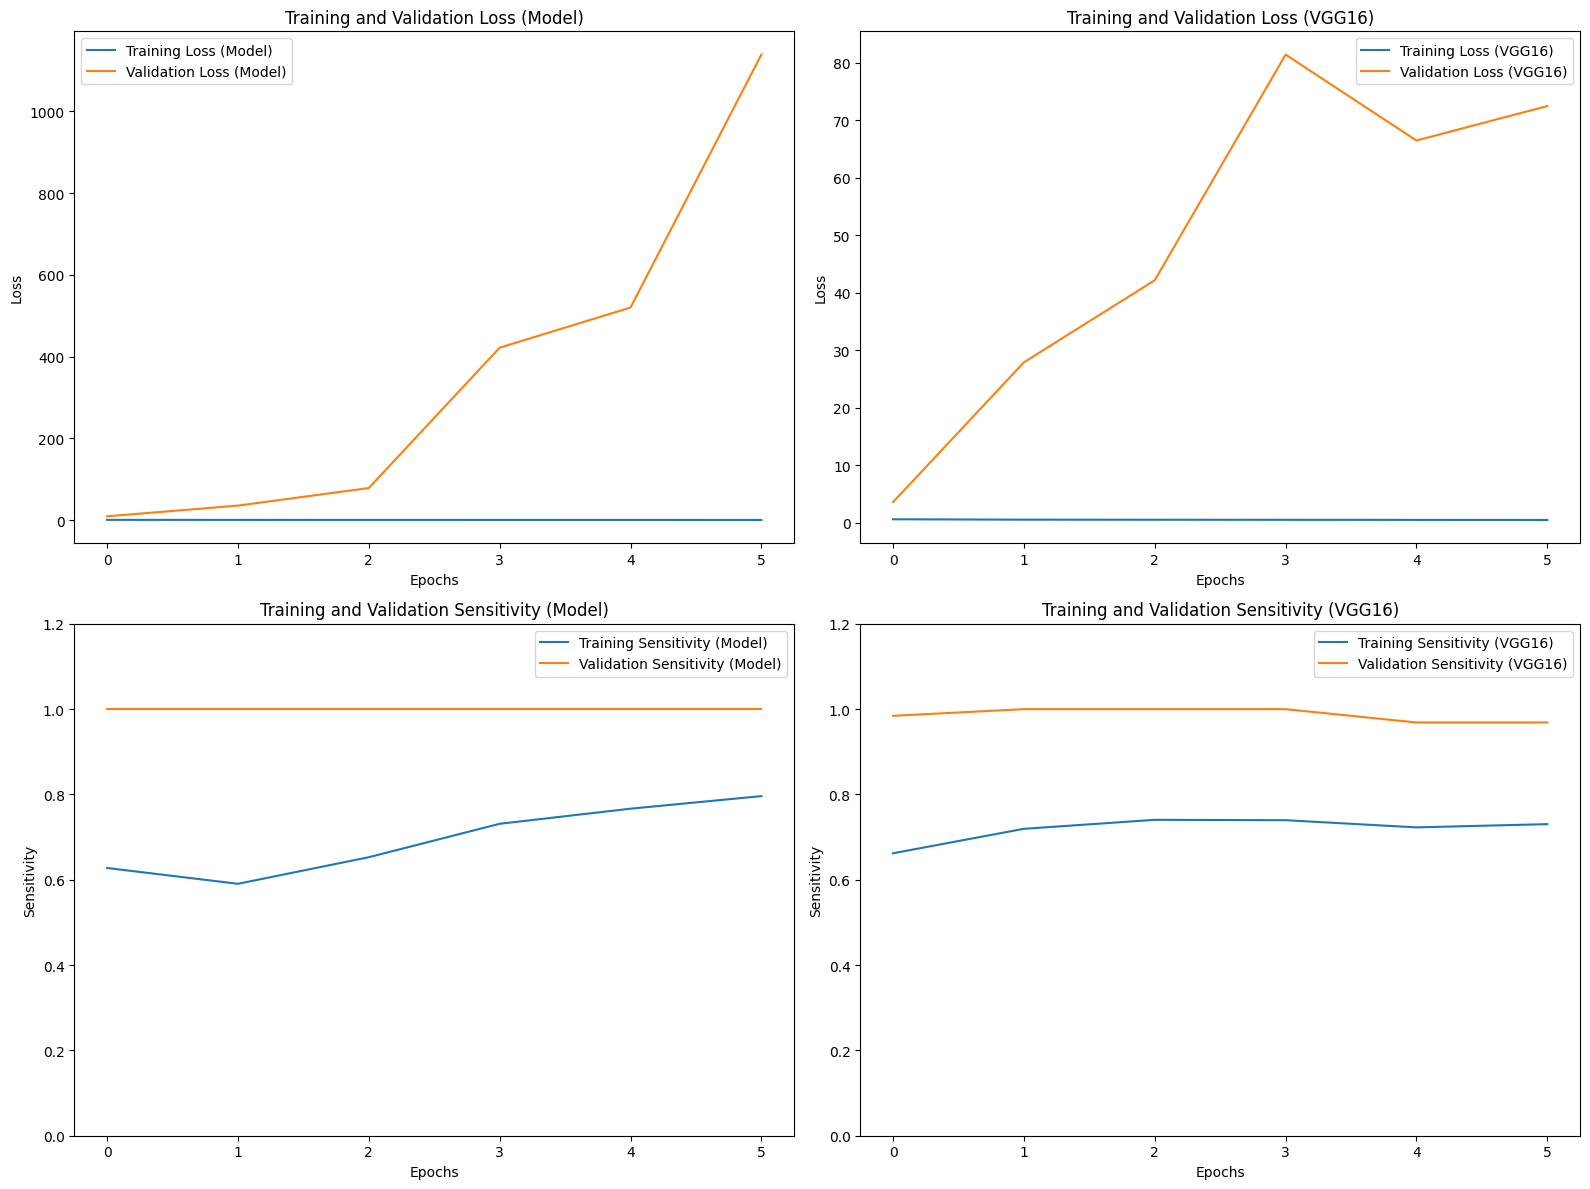

In [30]:
# Exemple d'us:
plot_training_history_dual(history, history_vgg16)

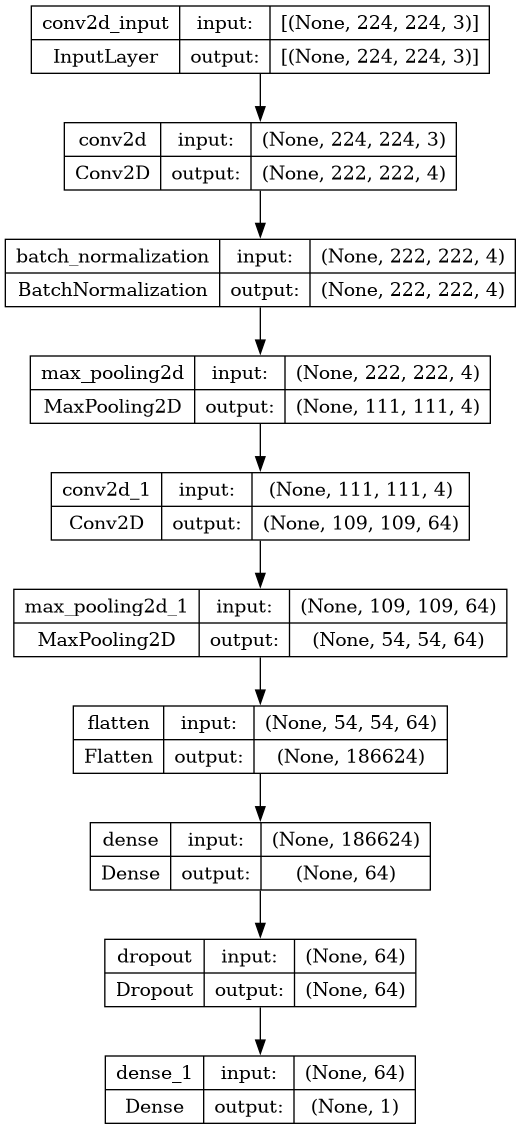

In [31]:
plot_model(model,to_file='/kaggle/working/model.png',show_shapes=True,show_layer_names=True)

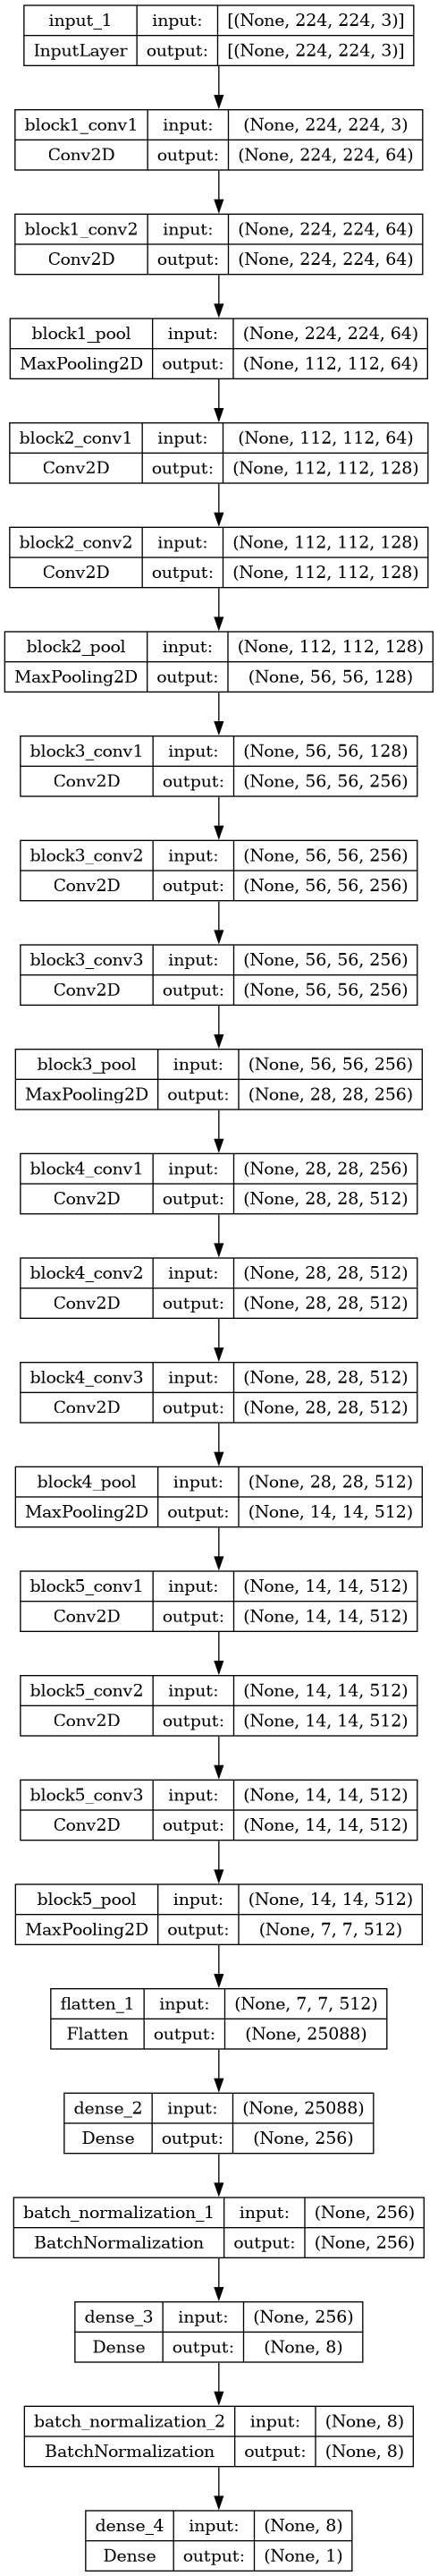

In [32]:
plot_model(model_vgg16,to_file='/kaggle/working/model_vgg16.png',show_shapes=True,show_layer_names=True)

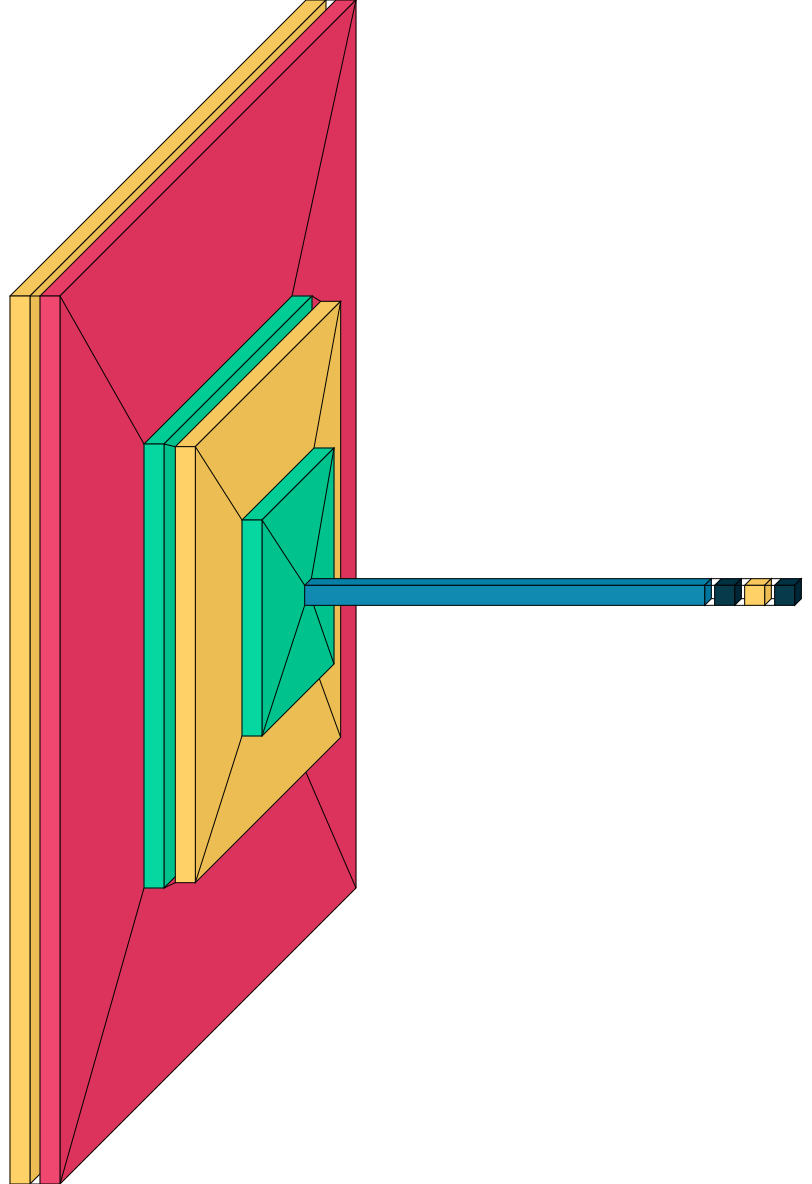

In [39]:
visualkeras.layered_view(model,to_file="model_layers.png")

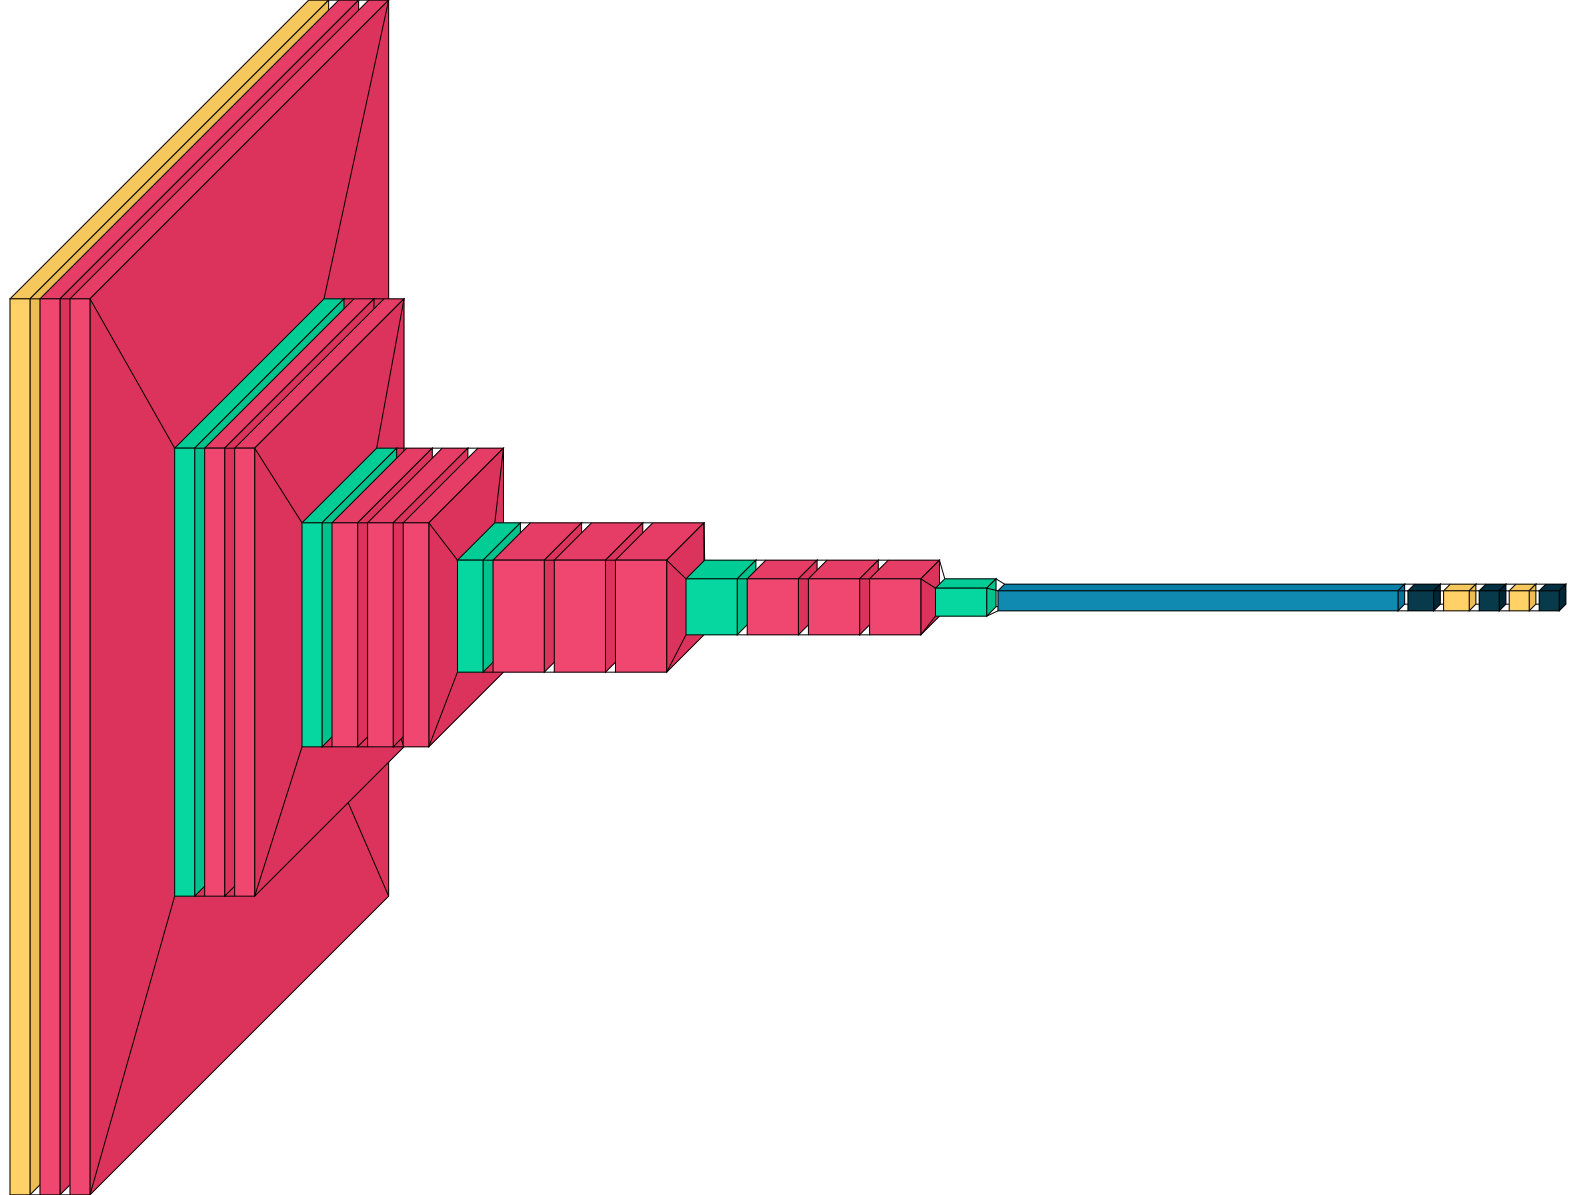

In [38]:
visualkeras.layered_view(model_vgg16,to_file="vgg16_layers.png")